In [1]:
import matplotlib.pyplot as plt
import numpy as np
from bilby.core.utils.constants import speed_of_light
from bilby.core.utils.conversion import theta_phi_to_ra_dec
from bilby.gw.detector import get_empty_interferometer, Interferometer
from bilby_rust.time import greenwich_mean_sidereal_time

In [2]:
def cartesian_to_spherical(vec):
    r = np.linalg.norm(vec)
    theta = np.arccos(vec[-1] / r)
    phi = np.arctan2(vec[1], vec[0])
    return theta, phi


antenna_response = None


class FrequencyDependentInterferometer(Interferometer):

    def optimal_orientation(self, time):
        """
        Calculate the optimal orientation of the interferometer at a given time.
        The maximal response is obtained when the line of sight is perpendicular
        to the interferometer arms.

        Parameters
        ==========
        time: float
            The GPS time to calculate the optimal orientation for

        Returns
        =======
        tuple: The right ascension and declination of the optimal orientation
        """
        theta, phi = cartesian_to_spherical(np.cross(self.geometry.y, self.geometry.x))
        gmst = greenwich_mean_sidereal_time(time) % (2 * np.pi)
        return theta_phi_to_ra_dec(theta, phi, gmst)

    @property
    def free_spectral_range(self):
        """
        The free spectral range of the interferometer.
        This is defined as the speed of light divided by the
        light travel time up and down an interferometer arm.

        Returns
        =======
        float: The free spectral range of the interferometer in Hz

        Notes
        =====
        The length is stored in kilometers, so we multiply by 1e3 to
        convert to meters
        """
        return speed_of_light / (2 * self.geometry.length * 1e3)

    def antenna_response(self, ra, dec, time, psi, mode, frequency=None):
        if frequency is None and getattr(self, "_frequencies", None) is None:
            frequency = super().antenna_response(ra, dec, time, psi, mode)
        elif frequency is None:
            frequency = self._frequencies
        return antenna_response(
            x=self.geometry.x,
            y=self.geometry.y,
            ra=ra,
            dec=dec,
            gps_time=time,
            psi=psi,
            mode=mode,
            frequency=frequency,
            free_spectral_range=self.free_spectral_range,
        )

    def get_detector_response(self, waveform_polarizations, parameters, frequencies=None):
        old_values = self._frequencies
        if frequencies is not None:
            self._frequencies = frequencies
        else:
            self._frequencies = self.strain_data.frequency_array
        response = super().get_detector_response(waveform_polarizations, parameters, frequencies)
        self._frequencies = old_values
        return response

    @classmethod
    def from_name(cls, name):
        """
        Create a known interferometer with a subclass of the interferometer.
        This is needed because :code:`bilby.gw.detector.get_empty_interferometer`
        returns an instance of :code:`Interferometer` and not any other subclass.

        This assumes the subclass can be initialized with
        :code:`Interferometer.__init__`. No checks are made to ensure the
        used class is consistent with the specification.
        """
        ifo = get_empty_interferometer(name)
        if isinstance(ifo, Interferometer):
            ifo.__class__ = cls
        elif isinstance(ifo, list):
            for elem in ifo:
                elem.__class__ = cls
        return ifo



In [3]:
def set_rust():
    global antenna_response
    from bilby_rust.geometry import antenna_response


def set_python():
    global antenna_response
    from utils import antenna_response

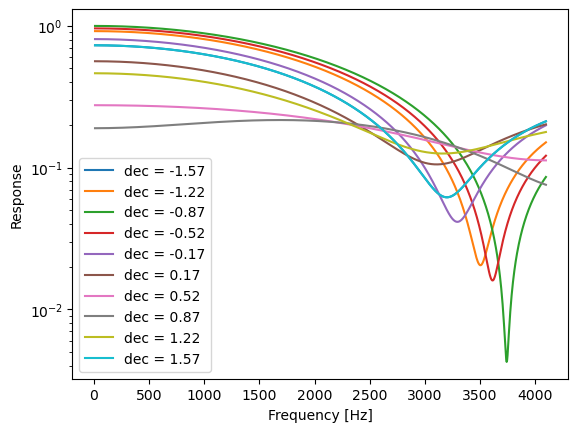

591 μs ± 32.5 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [6]:
ifo = FrequencyDependentInterferometer.from_name("CE")

set_rust()

ra, dec = ifo.optimal_orientation(0.0)

for dec in np.linspace(-np.pi / 2, np.pi / 2, 10):

    response = (
        abs(ifo.antenna_response(ra, dec, np.zeros(1000), 0.0, "plus", np.linspace(10, 4096, 1000)))**2
        + abs(ifo.antenna_response(ra, dec, np.zeros(1000), 0.0, "cross", np.linspace(10, 4096, 1000)))**2
    )**0.5

    plt.plot(np.linspace(10, 4096, 1000), abs(response), label=f"dec = {dec:.2f}")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Response")
plt.legend(loc="lower left")
plt.yscale("log")
plt.show()
plt.close()

# %timeit ifo.antenna_response(ra, dec, 0.0, 0.0, "plus", np.linspace(10, 4096, 1000))

%timeit ifo.antenna_response(ra, dec, np.zeros(1000), 0.0, "plus", np.linspace(10, 4096, 1000))

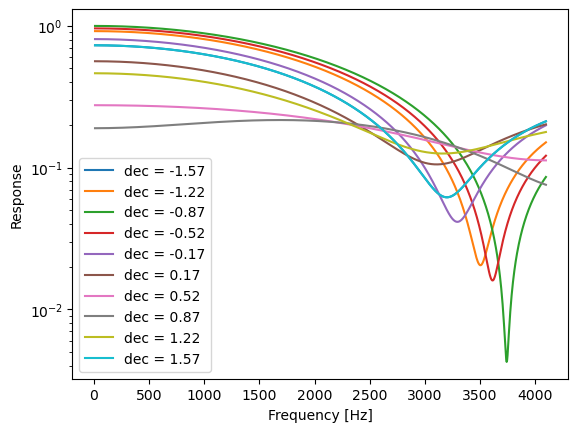

9.21 ms ± 564 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [5]:
set_python()

ra, dec = ifo.optimal_orientation(0.0)

for dec in np.linspace(-np.pi / 2, np.pi / 2, 10):

    response = (
        abs(ifo.antenna_response(ra, dec, 0.0, 0.0, "plus", np.linspace(10, 4096, 1000)))**2
        + abs(ifo.antenna_response(ra, dec, 0.0, 0.0, "cross", np.linspace(10, 4096, 1000)))**2
    )**0.5

    plt.plot(np.linspace(10, 4096, 1000), abs(response), label=f"dec = {dec:.2f}")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Response")
plt.legend(loc="lower left")
plt.yscale("log")
plt.show()
plt.close()

%timeit ifo.antenna_response(ra, dec, 0.0, 0.0, "plus", np.linspace(10, 4096, 1000))